## Design Backward Induction for the Simplified Soccer Case

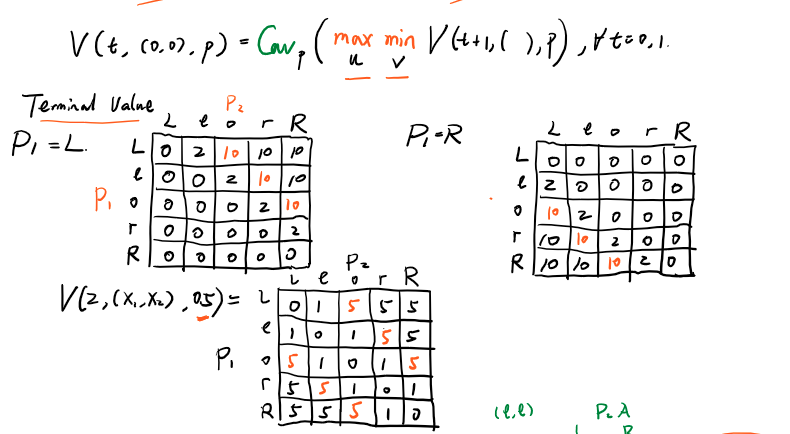

In [2]:
import numpy as np

In [3]:
# states, types, and actions
states = ['L', 'l', 'O', 'r', 'R']
types = ['L', 'R']
actions = ['L', 'R']

In [4]:
# final value for type R
val_R_T = np.zeros((len(states), len(states)))
val_R_T[np.triu_indices(5, k=1)] = 2
val_R_T[np.triu_indices(5, k=2)] = 10

# final value for type L
val_L_T = val_R_T.T

In [5]:
# get some numbers for easier calculations
import itertools

a_pairs = itertools.product(states, repeat=2)
a_pairs = np.array(list(a_pairs))    

In [6]:
a_pairs = np.array([[''.join(a_pairs[i, :]) for i in range(len(a_pairs))]]) # make array of action pairs

In [7]:
a_pairs = a_pairs.reshape(5, 5)

## Define a function to get value at some time t and probability p

In [8]:
def get_av_val(val_a, val_b, p):
    return p*val_a + (1-p)*val_b

In [9]:
def get_prev_val(game_dict, s): # game dict maps states --> payoff | s - states in grid
    temp = np.full(s.shape, np.nan)
    for i in range(1, 4):
        payoff = np.zeros((2, 2)) # payoff matrix for the game
        payoff[0, 0] = game_dict[s[0, i-1]] # left left 
        payoff[1, 0] = game_dict[s[4, i-1]] # right left
        payoff[0, 1] = game_dict[s[0, i+1]] # left right
        payoff[1, 1] = game_dict[s[4, i+1]] # right right
        
        # now find maximin
        temp[1, i] = np.max(np.min(payoff, 1))
    
    temp[2:4, 1:4] = temp[1, 1:4] # symmetric 
    
    return temp

In [10]:
# try manually for T-1 stage
av_game = get_av_val(val_R_T, val_L_T, 0.25)  # value of average game at time T
av_game_dict = dict(zip(list(a_pairs.flatten()), list(av_game.flatten())))

In [11]:
val_1 = get_prev_val(av_game_dict, a_pairs)

In [12]:
val_1

array([[nan, nan, nan, nan, nan],
       [nan, 7.5, 1.5, 2.5, nan],
       [nan, 7.5, 1.5, 2.5, nan],
       [nan, 7.5, 1.5, 2.5, nan],
       [nan, nan, nan, nan, nan]])

In [13]:
av_game

array([[0. , 0.5, 2.5, 2.5, 2.5],
       [1.5, 0. , 0.5, 2.5, 2.5],
       [7.5, 1.5, 0. , 0.5, 2.5],
       [7.5, 7.5, 1.5, 0. , 0.5],
       [7.5, 7.5, 7.5, 1.5, 0. ]])

In [14]:
ps = np.linspace(0, 1, 100)
l = [] # state l for p2 
O = [] # state O for p2
r = [] # state r for P2
for p in ps:
    av_game = get_av_val(val_R_T, val_L_T, p)
    av_dict = dict(zip(list(a_pairs.flatten()), list(av_game.flatten())))
    val_0 = get_prev_val(av_dict, a_pairs)
    l.append(val_0[1, 1])
    O.append(val_0[1, 2])
    r.append(val_0[1, 3])

In [15]:
import matplotlib.pyplot as plt

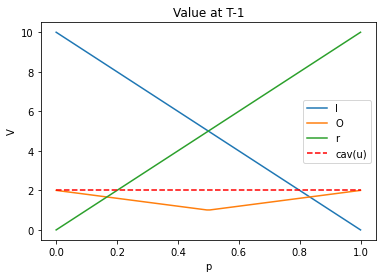

In [22]:
plt.plot(ps, l, label="l")
plt.plot(ps, O, label="O")
plt.plot(ps, r, label="r")
plt.xlabel('p')
plt.ylabel('V')
plt.title("Value at T-1")
plt.hlines(y=O[0], xmin=ps[0], xmax=ps[-1], color='red', linestyles='dashed', label="cav(u)")
plt.legend()

## Now lets look at P2's Value

In [17]:
def get_prev_val_2(game_dict, s):  # game dict maps states --> payoff | s - states in grid
    temp = np.zeros(s.shape)
    for i in range(1, 4):
        payoff = np.zeros((2, 2))  # payoff matrix for the game
        payoff[0, 0] = game_dict[s[0, i - 1]]  # left left
        payoff[1, 0] = game_dict[s[4, i - 1]]  # right left
        payoff[0, 1] = game_dict[s[0, i + 1]]  # left right
        payoff[1, 1] = game_dict[s[4, i + 1]]  # right right

        # now find maximin
        temp[1, i] = np.max(np.min(payoff, 0))

    temp[2:4, 1:4] = temp[1, 1:4]  # symmetric

    return temp

In [18]:
# the dual
p_hat = 10

In [19]:
min_game = np.minimum(p_hat-val_L_T, (10 - p_hat)-val_R_T)
min_game_dict = dict(zip(list(a_pairs.flatten()), list(min_game.flatten())))

val_2 = get_prev_val_2(min_game_dict, a_pairs)

print(min_game)
print(val_2)

[[  0.  -2. -10. -10. -10.]
 [  0.   0.  -2. -10. -10.]
 [  0.   0.   0.  -2. -10.]
 [  0.   0.   0.   0.  -2.]
 [  0.   0.   0.   0.   0.]]
[[  0.   0.   0.   0.   0.]
 [  0.   0.  -2. -10.   0.]
 [  0.   0.  -2. -10.   0.]
 [  0.   0.  -2. -10.   0.]
 [  0.   0.   0.   0.   0.]]


In [20]:
ps_hat = np.linspace(0, 10, 101)
val_2_p_t1 = np.zeros((ps_hat.shape[0], a_pairs.shape[0], a_pairs.shape[1]))

for i in range(len(ps_hat)):
    min_game = np.minimum(ps_hat[i] - val_L_T, (10 - ps_hat[i]) - val_R_T)
    min_game_dict = dict(zip(list(a_pairs.flatten()), list(min_game.flatten())))
    val_2_p_t1[i] = get_prev_val_2(min_game_dict, a_pairs)

val_2_p_t0 = np.zeros((ps_hat.shape[0], 2, 2))

for i in range(val_2_p_t0.shape[1]):
    for j in range(val_2_p_t0.shape[2]):
        val_2_p_t0[:, i, j] = val_2_p_t1[:, 2*i+1, 2*j+1]

payoff_t0 = np.zeros(ps_hat.shape[0])
strategy_t0 = list()

for i in range(val_2_p_t0.shape[0]):
    payoff_t0[i] = np.max(np.min(val_2_p_t0[i, :, :], 0))
    strategy_t0.append(actions[np.argmax(np.min(val_2_p_t0[i, :, :], 0))])

Text(0.5, 1.0, 'Value at T0')

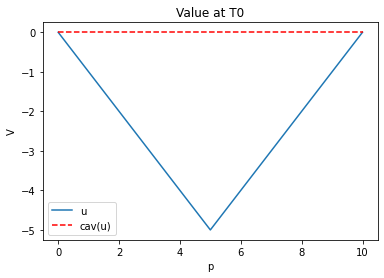

In [21]:
plt.plot(ps_hat, payoff_t0, label="u")
plt.hlines(y=0, xmin=ps_hat[0], xmax=ps_hat[-1], color='red', linestyles='dashed', label="cav(u)")
plt.legend()
plt.xlabel('p')
plt.ylabel('V')
plt.title("Value at T0")